In [304]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()

In [305]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/",'MultiScale'),
        ("/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/",'Sparse_IQP'),

]

for folder,prefix in folders:
    if prefix in dfs:
        temp = aggregate_shapes(folder,prefix)
        dfs[prefix] = pd.concat([dfs[prefix], temp])
    else:
        dfs[prefix] = aggregate_shapes(folder,prefix)


save_folder='/mnt/c/Users/lslat/Data/QK_project/figs/'

In [306]:
def kernel_shapes(df: pd.DataFrame,
    xlabel: str ,
    qubits: List[int] = [0],

    ):

    xs=copy.copy(df[xlabel].values)
    xs=list(set(xs))
    xs.sort()

    
    #get the rdms (and compute purity of averages) and norms differences and kernel values
    all_ps = []
    all_target_ps=[]
    all_norm_diffs =[]
    all_kvs = []
    for x in xs:
        try:
            ps=[]
            tps=[]
            #rdms=df.loc[(df[xlabel]==x)]['rdms'].values[0][:-1]
            rdms=df.loc[(df[xlabel]==x)]['rdms'].values[0][1:]
            #target_rdms=df.loc[(df[xlabel]==x)]['rdms'].values[0][-1]
            target_rdms=df.loc[(df[xlabel]==x)]['rdms'].values[0][0]


            for srdms in rdms[:,qubits]:
                avg_purity=0
                for rdm in srdms:
                    purity=np.trace(rdm @ rdm)
                    avg_purity+=purity/len(qubits)
                ps.append(avg_purity)
            all_ps.append(ps)

            for rdm in target_rdms[qubits]:
                purity = np.trace(rdm @ rdm)
                tps.append(purity)
            all_target_ps.append(tps)
        except:
            print('data frame does not have rdms')
            
        norm_diffs=df.loc[(df[xlabel]==x)]['norm_diffs'].values[0]

        kvs=df.loc[(df[xlabel]==x)]['qkern_matrix_train'].values[0]

        all_norm_diffs.append(norm_diffs)
        all_kvs.append(kvs)
    results={'xs':xs,'ps':all_ps,'norm_diffs':all_norm_diffs,'kvs':all_kvs,'target_ps':all_target_ps}    
    return results

Huang 'All' Qubit Projected Kernel for MultiScale Feature Map

In [307]:
df_MS=dfs['MultiScale']
dataset_dim=14
lam1=0.01
lam2=0.025
filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'lam1':lam1,'projected':'huang_proj'}
df_MS_hproj_flam1=filter_df(df_MS,filter)
filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'lam2':lam2,'projected':'huang_proj'}
df_MS_hproj_flam2=filter_df(df_MS,filter)

In [308]:
all_qubits=list(range(dataset_dim))
ms_hproj_flam1_results=kernel_shapes(df_MS_hproj_flam1,'lam2',all_qubits)
ms_hproj_flam2_results=kernel_shapes(df_MS_hproj_flam2,'lam1',all_qubits)

/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Single Qubit Projected Kernel for "MultiScale" feature map w/ $\\gamma=1.0$')

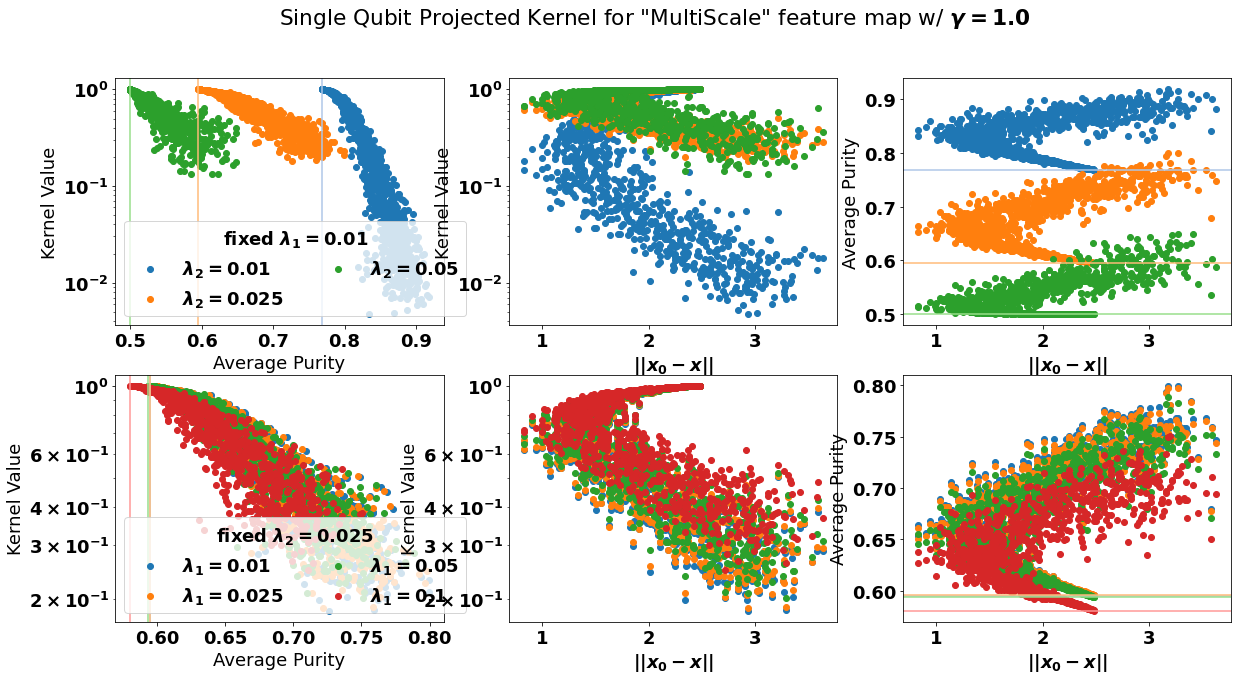

In [309]:
gamma=1.0
fig, axs = plt.subplots(2,3, figsize=(20, 10))
colors=cm.tab20.colors
###### Plot for Projected Kernel for fixed lambda1#####
#Get values to plot
xs=ms_hproj_flam1_results['xs']
ps=ms_hproj_flam1_results['ps']
target_ps=ms_hproj_flam1_results['target_ps']
norm_diffs=ms_hproj_flam1_results['norm_diffs']
kvs=ms_hproj_flam1_results['kvs']
#plot values
ax=axs[0][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$\lambda_2=$'+str(xs[i]),color=color1)
    ax.axvline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('Average Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $\lambda_1={lam1}$',ncol=2)
#plot values
ax=axs[0][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$\lambda_2=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[0][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$\lambda_2=$'+str(xs[i]),color=color1)
    ax.axhline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Average Purity')

###### Plot for Projected Kernel for fixed lambda2#####
#Get values to plot
xs=ms_hproj_flam2_results['xs']
ps=ms_hproj_flam2_results['ps']
target_ps=ms_hproj_flam2_results['target_ps']
norm_diffs=ms_hproj_flam2_results['norm_diffs']
kvs=ms_hproj_flam2_results['kvs']
#plot values
ax=axs[1][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$\lambda_1=$'+str(xs[i]),color=color1)
    ax.axvline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('Average Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $\lambda_2={lam2}$',ncol=2)
#plot values
ax=axs[1][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$\lambda_1=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[1][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$\lambda_1=$'+str(xs[i]),color=color1)
    ax.axhline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Average Purity')

fig.suptitle(f'Single Qubit Projected Kernel for "MultiScale" feature map w/ $\gamma={gamma}$')

Single Qubit Projected Kernel for MultiScale Feature Map

In [310]:
df_MS=dfs['MultiScale']
dataset_dim=14
lam1=0.01
lam2=0.025
filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'lam1':lam1,'projected':'single_proj'}
df_MS_sproj_flam1=filter_df(df_MS,filter)
filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'lam2':lam2,'projected':'single_proj'}
df_MS_sproj_flam2=filter_df(df_MS,filter)


In [311]:
ms_sproj_flam1_results=kernel_shapes(df_MS_sproj_flam1,'lam2',[0])
ms_sproj_flam2_results=kernel_shapes(df_MS_sproj_flam2,'lam1',[0])

/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Single Qubit Projected Kernel for "MultiScale" feature map w/ $\\gamma=1.0$')

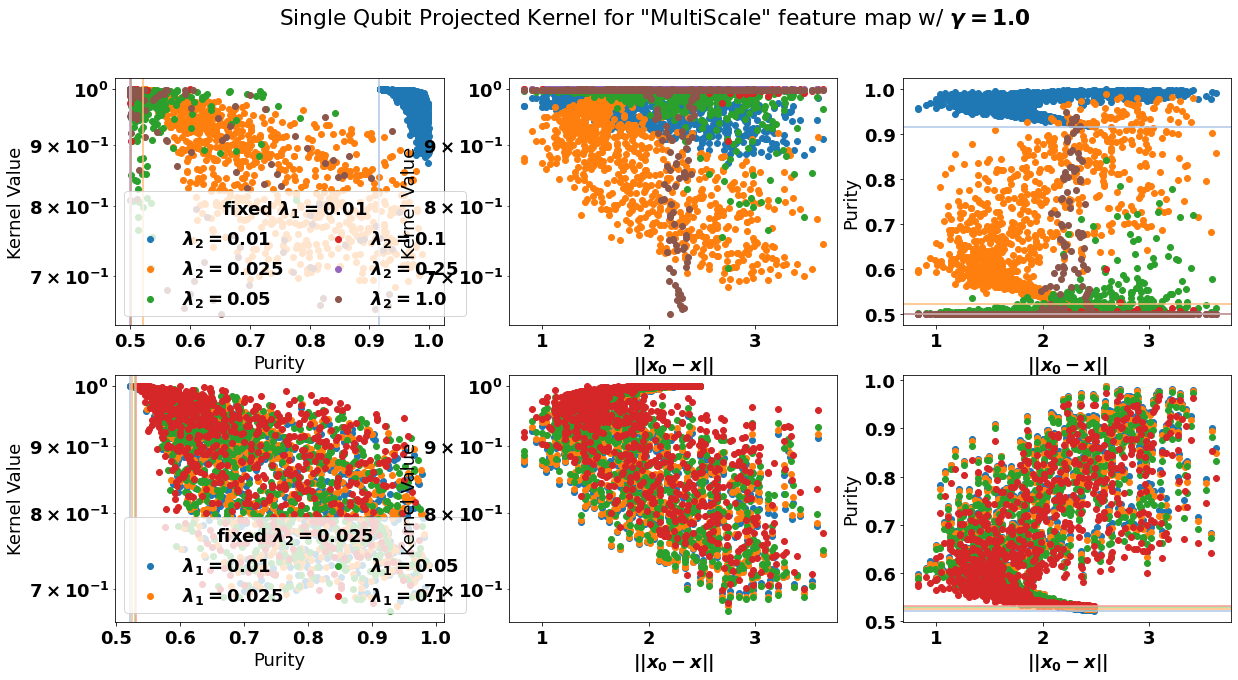

In [312]:
gamma=1.0
fig, axs = plt.subplots(2,3, figsize=(20, 10))
colors=cm.tab20.colors
###### Plot for Projected Kernel for fixed lambda1#####
#Get values to plot
xs=ms_sproj_flam1_results['xs']
ps=ms_sproj_flam1_results['ps']
target_ps=ms_sproj_flam1_results['target_ps']
norm_diffs=ms_sproj_flam1_results['norm_diffs']
kvs=ms_sproj_flam1_results['kvs']
#plot values
ax=axs[0][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$\lambda_2=$'+str(xs[i]),color=color1)
    ax.axvline(target_ps[i],color=color2)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $\lambda_1={lam1}$',ncol=2)
#plot values
ax=axs[0][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$\lambda_2=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[0][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$\lambda_2=$'+str(xs[i]),color=color1)
    ax.axhline(target_ps[i],color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Purity')

###### Plot for Projected Kernel for fixed lambda2#####
#Get values to plot
xs=ms_sproj_flam2_results['xs']
ps=ms_sproj_flam2_results['ps']
target_ps=ms_sproj_flam2_results['target_ps']
norm_diffs=ms_sproj_flam2_results['norm_diffs']
kvs=ms_sproj_flam2_results['kvs']
#plot values
ax=axs[1][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$\lambda_1=$'+str(xs[i]),color=color1)
    ax.axvline(target_ps[i],color=color2)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $\lambda_2={lam2}$',ncol=2)
#plot values
ax=axs[1][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$\lambda_1=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[1][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$\lambda_1=$'+str(xs[i]),color=color1)
    ax.axhline(target_ps[i],color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Purity')

fig.suptitle(f'Single Qubit Projected Kernel for "MultiScale" feature map w/ $\gamma={gamma}$')

Fidelity Kernel for MultiScale Feature Map

In [313]:
df_MS=dfs['MultiScale']
dataset_dim=14
lam1=0.01
lam2=0.025
filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'lam1':lam1,'projected':''}
df_MS_fid_flam1=filter_df(df_MS,filter)
filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'lam2':lam2,'projected':''}
df_MS_fid_flam2=filter_df(df_MS,filter)

In [314]:
ms_fid_flam1_results=kernel_shapes(df_MS_fid_flam1,'lam2',0)
ms_fid_flam2_results=kernel_shapes(df_MS_fid_flam2,'lam1',0)

data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms


Text(0.5, 0.98, 'Fidelity Kernel for "MultiScale" feature map')

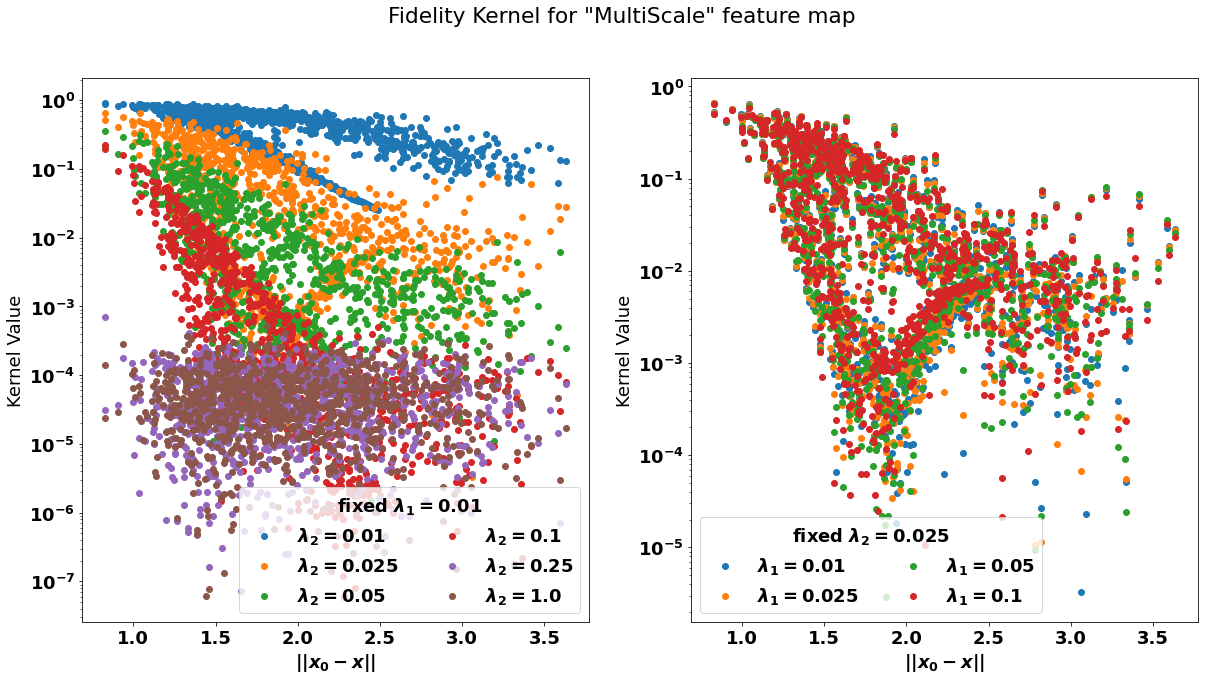

In [315]:
gamma=1.0
fig, axs = plt.subplots(1,2, figsize=(20, 10))
colors=cm.tab20.colors
###### Plot for Projected Kernel for fixed lambda1#####
#Get values to plot
xs=ms_fid_flam1_results['xs']
norm_diffs=ms_fid_flam1_results['norm_diffs']
kvs=ms_fid_flam1_results['kvs']
#plot values
ax=axs[0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(norm_diffs[i],gamma*kvs[i],label='$\lambda_2=$'+str(xs[i]),color=color1)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $\lambda_1={lam1}$',ncol=2)

###### Plot for Projected Kernel for fixed lambda2#####
#Get values to plot
xs=ms_fid_flam2_results['xs']
norm_diffs=ms_fid_flam2_results['norm_diffs']
kvs=ms_fid_flam2_results['kvs']
#plot values
ax=axs[1]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(norm_diffs[i],kvs[i],label='$\lambda_1=$'+str(xs[i]),color=color1)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $\lambda_2={lam2}$',ncol=2)

fig.suptitle(f'Fidelity Kernel for "MultiScale" feature map')

Huang 'All' Qubit Projected Quantum Kernel with IQP Feature Map

In [316]:
df_IQP=dfs['Sparse_IQP']
dataset_dim=14
lisf0=0.0
filter={'dataset_dim':dataset_dim,'density':dataset_dim-1,'log_int_scaling_factor':lisf0,'projected':'huang_proj'}
df_IQP_lisf0=filter_df(df_IQP,filter)

lisf1=-2.0
filter={'dataset_dim':dataset_dim,'density':dataset_dim-1,'log_int_scaling_factor':lisf1,'projected':'huang_proj'}
df_IQP_lisf1=filter_df(df_IQP,filter)


In [317]:
all_qubits=list(range(dataset_dim))
iqp_hproj_results0=kernel_shapes(df_IQP_lisf0,'log_scaling_factor',all_qubits)
iqp_hproj_results1=kernel_shapes(df_IQP_lisf1,'log_scaling_factor',all_qubits)

/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Huang All Qubit Projected Kernel for IQP feature map w/ $\\gamma=1.0$')

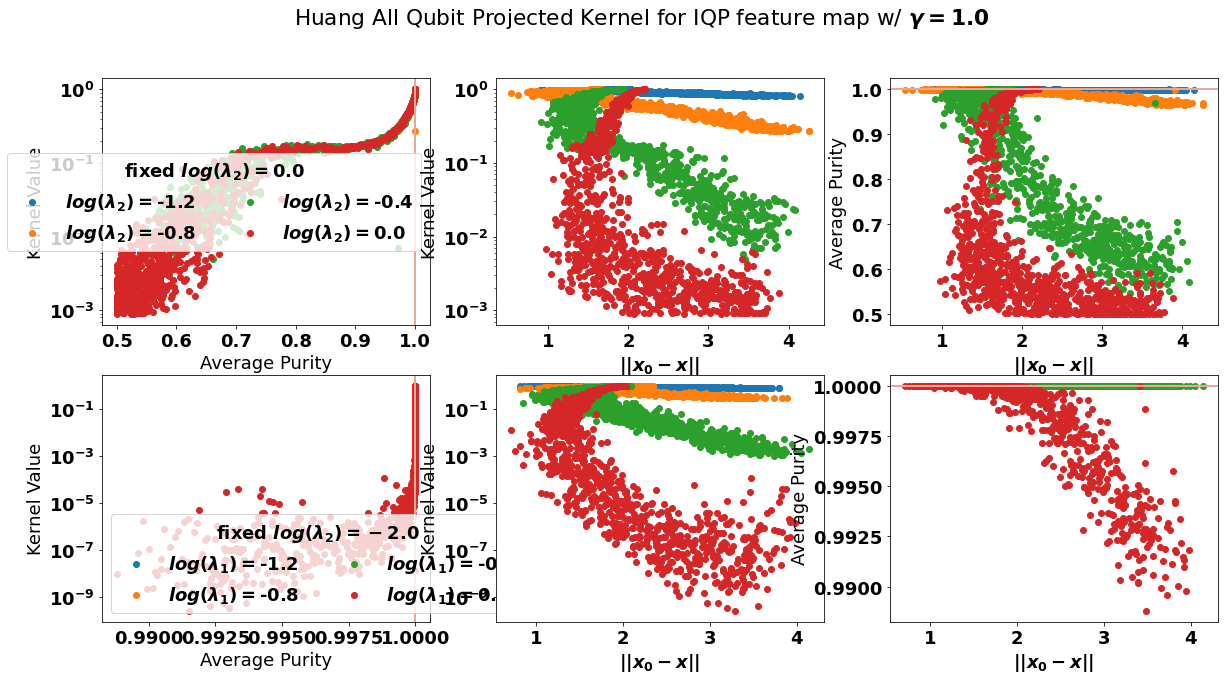

In [318]:
gamma=1.0
fig, axs = plt.subplots(2,3, figsize=(20, 10))
colors=cm.tab20.colors
###### Plot for Projected Kernel for fixed lambda1#####
#Get values to plot
xs=iqp_hproj_results0['xs']
ps=iqp_hproj_results0['ps']
target_ps=iqp_hproj_results0['target_ps']
norm_diffs=iqp_hproj_results0['norm_diffs']
kvs=iqp_hproj_results0['kvs']
#plot values
ax=axs[0][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_2)=$'+str(xs[i]),color=color1)
    ax.axvline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('Average Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $log(\lambda_2)={lisf0}$',ncol=2)
#plot values
ax=axs[0][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_2)=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[0][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
    ax.axhline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Average Purity')

###### Plot for Projected Kernel for fixed lambda2#####
#Get values to plot
xs=iqp_hproj_results1['xs']
ps=iqp_hproj_results1['ps']
target_ps=iqp_hproj_results1['target_ps']
norm_diffs=iqp_hproj_results1['norm_diffs']
kvs=iqp_hproj_results1['kvs']
#plot values
ax=axs[1][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
    ax.axvline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('Average Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $log(\lambda_2)={lisf1}$',ncol=2)
#plot values
ax=axs[1][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[1][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
    ax.axhline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Average Purity')

fig.suptitle(f'Huang All Qubit Projected Kernel for IQP feature map w/ $\gamma={gamma}$')

Single Qubit Projected Kernel with IQP Feature Map

In [319]:
df_IQP=dfs['Sparse_IQP']
dataset_dim=14
lisf0=0.0
filter={'dataset_dim':dataset_dim,'density':dataset_dim-1,'log_int_scaling_factor':lisf0,'projected':'single_proj'}
df_IQP_lisf0=filter_df(df_IQP,filter)

lisf1=-2.0
filter={'dataset_dim':dataset_dim,'density':dataset_dim-1,'log_int_scaling_factor':lisf1,'projected':'single_proj'}
df_IQP_lisf1=filter_df(df_IQP,filter)

In [320]:
iqp_sproj_results0=kernel_shapes(df_IQP_lisf0,'log_scaling_factor',[0])
iqp_sproj_results1=kernel_shapes(df_IQP_lisf1,'log_scaling_factor',[0])

/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Single Qubit Projected Kernel for IQP feature map w/ $\\gamma=1.0$')

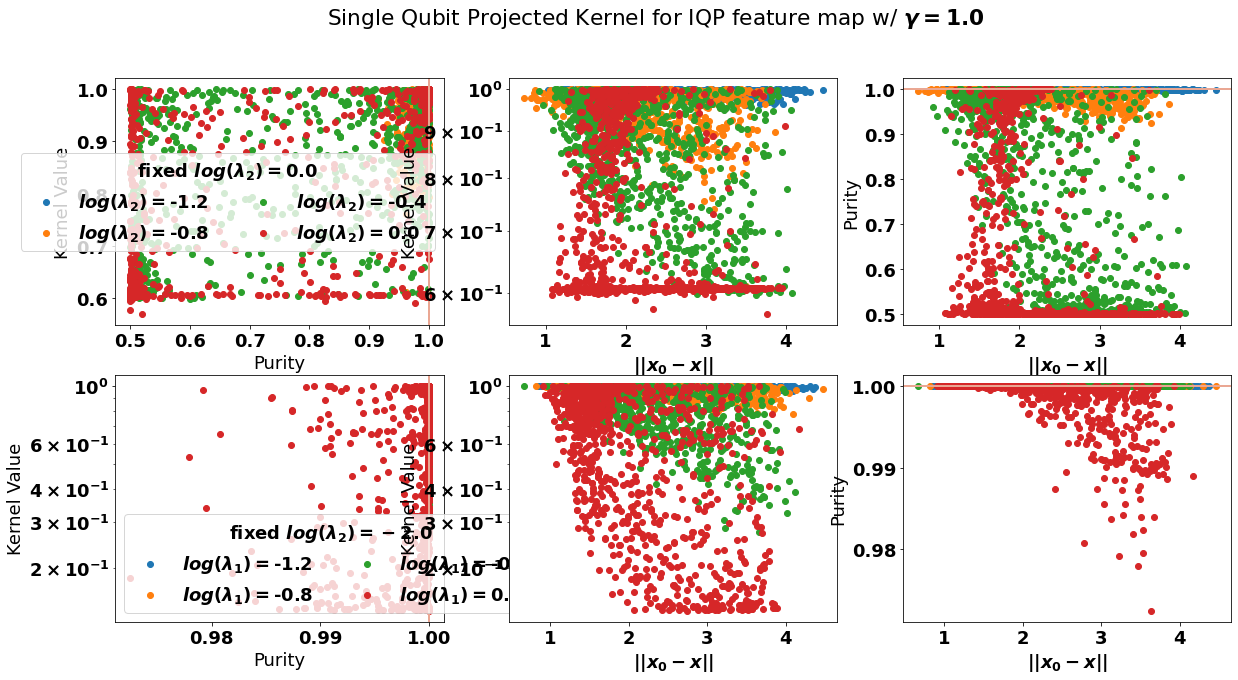

In [321]:
gamma=1.0
fig, axs = plt.subplots(2,3, figsize=(20, 10))
colors=cm.tab20.colors
###### Plot for Projected Kernel for fixed lambda1#####
#Get values to plot
xs=iqp_sproj_results0['xs']
ps=iqp_sproj_results0['ps']
target_ps=iqp_sproj_results0['target_ps']
norm_diffs=iqp_sproj_results0['norm_diffs']
kvs=iqp_sproj_results0['kvs']
#plot values
ax=axs[0][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_2)=$'+str(xs[i]),color=color1)
    ax.axvline(np.mean(target_ps[i]),color=color2)

#make pretty
#ax.set_yscale('log')
ax.set_xlabel('Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $log(\lambda_2)={lisf0}$',ncol=2)
#plot values
ax=axs[0][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_2)=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[0][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
    ax.axhline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Purity')

###### Plot for Projected Kernel for fixed lambda2#####
#Get values to plot
xs=iqp_sproj_results1['xs']
ps=iqp_sproj_results1['ps']
target_ps=iqp_sproj_results1['target_ps']
norm_diffs=iqp_sproj_results1['norm_diffs']
kvs=iqp_sproj_results1['kvs']
#plot values
ax=axs[1][0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(ps[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
    ax.axvline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('Purity')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $log(\lambda_2)={lisf1}$',ncol=2)
#plot values
ax=axs[1][1]
for i in range(len(xs)):
    color1=colors[2*i]
    ax.scatter(norm_diffs[i],np.exp(-gamma*kvs[i]),label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
#plot values
ax=axs[1][2]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]

    ax.scatter(norm_diffs[i],ps[i],label='$log(\lambda_1)=$'+str(xs[i]),color=color1)
    ax.axhline(np.mean(target_ps[i]),color=color2)

#make pretty
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Purity')

fig.suptitle(f'Single Qubit Projected Kernel for IQP feature map w/ $\gamma={gamma}$')

Fidelity Kernel with IQP feature map

In [322]:
df_IQP=dfs['Sparse_IQP']
dataset_dim=14
lisf0=0.0
filter={'dataset_dim':dataset_dim,'density':dataset_dim-1,'log_int_scaling_factor':lisf0,'projected':''}
df_IQP_lisf0=filter_df(df_IQP,filter)

lisf1=-2.0
filter={'dataset_dim':dataset_dim,'density':dataset_dim-1,'log_int_scaling_factor':lisf1,'projected':''}
df_IQP_lisf1=filter_df(df_IQP,filter)

In [323]:
iqp_fid_results0=kernel_shapes(df_IQP_lisf0,'log_scaling_factor')
iqp_fid_results1=kernel_shapes(df_IQP_lisf1,'log_scaling_factor')

data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms
data frame does not have rdms


Text(0.5, 0.98, 'Fidelity Kernel for "MultiScale" feature map')

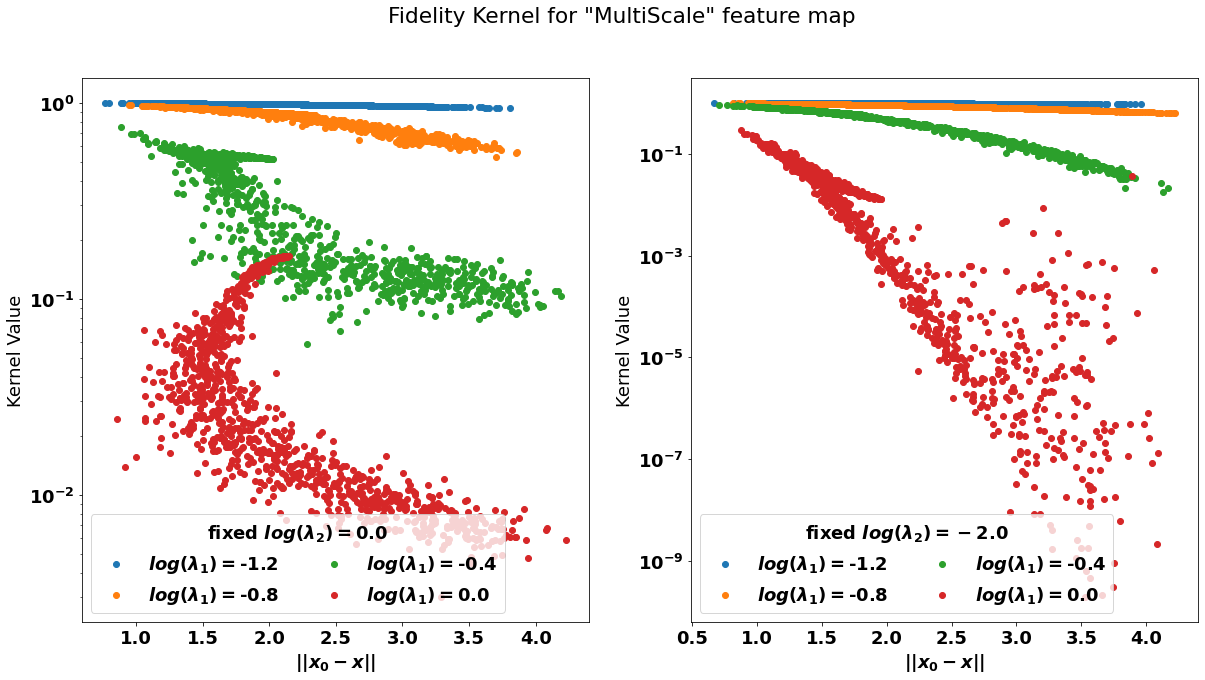

In [324]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
colors=cm.tab20.colors
###### Plot for Projected Kernel for fixed lambda1#####
#Get values to plot
xs=iqp_fid_results0['xs']
norm_diffs=iqp_fid_results0['norm_diffs']
kvs=iqp_fid_results0['kvs']
#plot values
ax=axs[0]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(norm_diffs[i],gamma*kvs[i],label='$log(\lambda_1)=$'+str(xs[i]),color=color1)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $log(\lambda_2)={lisf0}$',ncol=2)

###### Plot for Projected Kernel for fixed lambda2#####
#Get values to plot
xs=iqp_fid_results1['xs']
norm_diffs=iqp_fid_results1['norm_diffs']
kvs=iqp_fid_results1['kvs']
#plot values
ax=axs[1]
for i in range(len(xs)):
    color1=colors[2*i]
    color2=colors[2*i+1]
    ax.scatter(norm_diffs[i],kvs[i],label='$log(\lambda_1)=$'+str(xs[i]),color=color1)

#make pretty
ax.set_yscale('log')
ax.set_xlabel('$\||x_0-x\||$')
ax.set_ylabel('Kernel Value')
ax.legend(title=f'fixed $log(\lambda_2)={lisf1}$',ncol=2)

fig.suptitle(f'Fidelity Kernel for IQP feature map')

In [329]:
from qiskit.quantum_info.operators.symplectic import Pauli
